# **1- DATA COLLECTION**

**Import packages**

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("nlp news").getOrCreate()

In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover
from pyspark.ml.classification import NaiveBayes, DecisionTreeClassifier,LogisticRegression,RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import StringType,IntegerType
from pyspark.sql.functions import col,udf,isnull, regexp_replace 
import pyarrow as pa
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud


**Data collection**

In [4]:
news_data = spark.read.csv('newsdataset.csv', header= 'True', inferSchema= 'True')

In [5]:
news_data.show()

+---+--------------------+--------------------+--------------------+--------+--------------------+--------------------+-------------+
| ID|               TITLE|                 URL|           PUBLISHER|CATEGORY|               STORY|            HOSTNAME|    TIMESTAMP|
+---+--------------------+--------------------+--------------------+--------+--------------------+--------------------+-------------+
|  1|Fed official says...|http://www.latime...|   Los Angeles Times|       b|ddUyU0VZz0BRneMio...|     www.latimes.com|1394470370698|
|  2|Fed's Charles Plo...|http://www.livemi...|            Livemint|       b|ddUyU0VZz0BRneMio...|    www.livemint.com|1394470371207|
|  3|US open: Stocks f...|http://www.ifamag...|        IFA Magazine|       b|ddUyU0VZz0BRneMio...| www.ifamagazine.com|1394470371550|
|  4|Fed risks falling...|http://www.ifamag...|        IFA Magazine|       b|ddUyU0VZz0BRneMio...| www.ifamagazine.com|1394470371793|
|  5|Fed's Plosser: Na...|http://www.moneyn...|           Mone

**Schema and data Shape**

In [6]:
news_data.printSchema()

root
 |-- ID: string (nullable = true)
 |-- TITLE: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- PUBLISHER: string (nullable = true)
 |-- CATEGORY: string (nullable = true)
 |-- STORY: string (nullable = true)
 |-- HOSTNAME: string (nullable = true)
 |-- TIMESTAMP: string (nullable = true)



In [7]:
# get columns and rows 
print(news_data.count())
print(len(news_data.columns))

422937
8


**Title and Category Dataset**

In [8]:
# Get Only title and categories
title_categories = news_data.select('TITLE','CATEGORY')
title_categories.show(truncate=False)

+---------------------------------------------------------------------------+--------+
|TITLE                                                                      |CATEGORY|
+---------------------------------------------------------------------------+--------+
|Fed official says weak data caused by weather, should not slow taper       |b       |
|Fed's Charles Plosser sees high bar for change in pace of tapering         |b       |
|US open: Stocks fall after Fed official hints at accelerated tapering      |b       |
|Fed risks falling 'behind the curve', Charles Plosser says                 |b       |
|Fed's Plosser: Nasty Weather Has Curbed Job Growth                         |b       |
|Plosser: Fed May Have to Accelerate Tapering Pace                          |b       |
|Fed's Plosser: Taper pace may be too slow                                  |b       |
|Fed's Plosser expects US unemployment to fall to 6.2% by the end of 2014   |b       |
|US jobs growth last month hit by weather:F

In [9]:
# Null values in TITLE AND CATEGORIES 
print(title_categories.where(col('TITLE').isNull()).count())
print(title_categories.where(col('CATEGORY').isNull()).count())



389
516


In [10]:
# Display Nullvalues Table
news_data.where(col('TITLE').isNull() | col('CATEGORY').isNull()).show(15)

+--------------------+--------------------+--------------------+---------+--------+-----+--------+---------+
|                  ID|               TITLE|                 URL|PUBLISHER|CATEGORY|STORY|HOSTNAME|TIMESTAMP|
+--------------------+--------------------+--------------------+---------+--------+-----+--------+---------+
|               69474|Love & Hip-Hop' S...|                null|     null|    null| null|    null|     null|
|69475\t'Love & Hi...| wounded\thttp://...|                null|     null|    null| null|    null|     null|
|69476\tRapper Ben...|                null|                null|     null|    null| null|    null|     null|
|69477\tLove & Hip...|                null|                null|     null|    null| null|    null|     null|
|69478\t'Love & Hi...|             Benzino| shot at mother's...|     null|    null| null|    null|     null|
|69479\tReality TV...|                null|                null|     null|    null| null|    null|     null|
|69480\tWeekend Wr.

In [11]:
#Overall titleCategories Dataset
print(title_categories.count())
print(len(title_categories.columns))

422937
2


In [12]:
# We have 400k data so we decide not to keep these rows. Let's drop them
title_categories = title_categories.dropna()

In [13]:
title_categories.count()

422421

**Unique categories**

In [14]:
# Find unique categories
title_categories.select('CATEGORY').distinct().count()

265

In [15]:
# List few of them - 
print(title_categories.select('CATEGORY').distinct().show(truncate=False))

+--------------------------------------------------------------------------------------------------------------------+
|CATEGORY                                                                                                            |
+--------------------------------------------------------------------------------------------------------------------+
|Pitchfork Media                                                                                                     |
|http://grist.org/climate-energy/neil-degrasse-tyson-on-cosmos-how-science-got-cool-and-why-he-doesnt-debate-deniers/|
|FasterLouder                                                                                                        |
|Greenfield Daily Reporter                                                                                           |
|WXYZ                                                                                                                |
|dVcLyu7MZ2lvOuM8psiqi0ay7A2GM                  

**Top categories**

In [16]:
# Let'group them, count and display again in order
title_categories.groupBy('CATEGORY').count().orderBy(col('count').desc()).show(truncate=False)

+--------------------+------+
|CATEGORY            |count |
+--------------------+------+
|e                   |152127|
|b                   |115935|
|t                   |108237|
|m                   |45616 |
|Us Magazine         |31    |
|GossipCop           |20    |
|Contactmusic.com    |20    |
|Complex.com         |12    |
|CBS News            |12    |
|The Hollywood Gossip|11    |
|HipHopDX            |11    |
|HeadlinePlanet.com  |10    |
|We Got This Covered |10    |
|Gamepur             |8     |
|WorstPreviews.com   |7     |
|Wetpaint            |7     |
|TooFab.com          |7     |
|Consequence of Sound|7     |
|The Escapist        |6     |
|Reality TV World    |5     |
+--------------------+------+
only showing top 20 rows



In [17]:
title_categories_hist = title_categories.groupBy('CATEGORY').count().orderBy(col('count').desc())
title_categories_hist_10 = title_categories_hist.where(col('count')>10)
title_categories_hist.where(col('count')>10).show(truncate=False)

+--------------------+------+
|CATEGORY            |count |
+--------------------+------+
|e                   |152127|
|b                   |115935|
|t                   |108237|
|m                   |45616 |
|Us Magazine         |31    |
|GossipCop           |20    |
|Contactmusic.com    |20    |
|CBS News            |12    |
|Complex.com         |12    |
|The Hollywood Gossip|11    |
|HipHopDX            |11    |
+--------------------+------+



In [18]:
# Enable Arrow-based columnar data 
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
result_pdf = title_categories_hist_10.select("*").toPandas()
result_pdf

,CATEGORY,count
0,e,152127
1,b,115935
2,t,108237
3,m,45616
4,Us Magazine,31
5,Contactmusic.com,20
6,GossipCop,20
7,CBS News,12
8,Complex.com,12
9,The Hollywood Gossip,11


In [19]:
result_pdf.set_index(result_pdf['CATEGORY'],inplace=True)

Text(0, 0.5, 'number of tiimes')

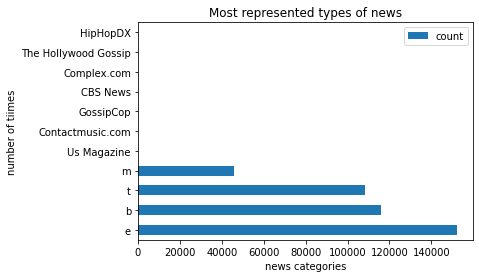

In [20]:
result_pdf.plot(kind="barh")
plt.title('Most represented types of news')
plt.xlabel('news categories')
plt.ylabel('number of tiimes')


**Top Title**

In [21]:
title_categories.groupBy(col('TITLE')).count().orderBy(col('count').desc()).show(truncate=False)

+----------------------------------------------------------------------------------+-----+
|TITLE                                                                             |count|
+----------------------------------------------------------------------------------+-----+
|The article requested cannot be found! Please refresh your browser or go back  ...|145  |
|Business Highlights                                                               |59   |
|Posted by Parvez Jabri                                                            |59   |
|Posted by Imaduddin                                                               |53   |
|Posted by Shoaib-ur-Rehman Siddiqui                                               |52   |
|(click the phrases to see a list)                                                 |51   |
|Business Wire                                                                     |41   |
|PR Newswire                                                                       |38   |

# **2- DATA PREPROCESSING**

In [22]:
# Removing numbers from title
title_categories = title_categories.withColumn('JustString', regexp_replace(col('TITLE'), '\d+',''))

In [23]:
title_categories.select('TITLE','JustString').show(truncate=False)

+---------------------------------------------------------------------------+---------------------------------------------------------------------------+
|TITLE                                                                      |JustString                                                                 |
+---------------------------------------------------------------------------+---------------------------------------------------------------------------+
|Fed official says weak data caused by weather, should not slow taper       |Fed official says weak data caused by weather, should not slow taper       |
|Fed's Charles Plosser sees high bar for change in pace of tapering         |Fed's Charles Plosser sees high bar for change in pace of tapering         |
|US open: Stocks fall after Fed official hints at accelerated tapering      |US open: Stocks fall after Fed official hints at accelerated tapering      |
|Fed risks falling 'behind the curve', Charles Plosser says                 

In [24]:
# Split text into words(from string to array of string, convert to lowercase)
# transform: string --> array<string>  ;sometimes used to buildlike building a feature vector
regex_tokenizer = RegexTokenizer(inputCol='JustString', outputCol='words', pattern="\\W")
raw_words = regex_tokenizer.transform(title_categories)

In [25]:
raw_words.select('TITLE','JustString','words').show(20,50)

+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|                                             TITLE|                                        JustString|                                             words|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|Fed official says weak data caused by weather, ...|Fed official says weak data caused by weather, ...|[fed, official, says, weak, data, caused, by, w...|
|Fed's Charles Plosser sees high bar for change ...|Fed's Charles Plosser sees high bar for change ...|[fed, s, charles, plosser, sees, high, bar, for...|
|US open: Stocks fall after Fed official hints a...|US open: Stocks fall after Fed official hints a...|[us, open, stocks, fall, after, fed, official, ...|
|Fed risks falling 'behind the curve', Charles P...|Fed risks falling 

In [26]:
# Remove stopswords 
remover = StopWordsRemover(inputCol='words', outputCol='filtered')
words_df = remover.transform(raw_words)

In [27]:
words_df.select('words','filtered').show(20,70)

+----------------------------------------------------------------------+----------------------------------------------------------------------+
|                                                                 words|                                                              filtered|
+----------------------------------------------------------------------+----------------------------------------------------------------------+
|[fed, official, says, weak, data, caused, by, weather, should, not,...|       [fed, official, says, weak, data, caused, weather, slow, taper]|
|[fed, s, charles, plosser, sees, high, bar, for, change, in, pace, ...|      [fed, charles, plosser, sees, high, bar, change, pace, tapering]|
|[us, open, stocks, fall, after, fed, official, hints, at, accelerat...| [us, open, stocks, fall, fed, official, hints, accelerated, tapering]|
|     [fed, risks, falling, behind, the, curve, charles, plosser, says]|          [fed, risks, falling, behind, curve, charles, plosser,

In [28]:
data_cloud = words_df.select('*').toPandas()
data_cloud

,TITLE,CATEGORY,JustString,words,filtered
0,"Fed official says weak data caused by weather,...",b,"Fed official says weak data caused by weather,...","[fed, official, says, weak, data, caused, by, ...","[fed, official, says, weak, data, caused, weat..."
1,Fed's Charles Plosser sees high bar for change...,b,Fed's Charles Plosser sees high bar for change...,"[fed, s, charles, plosser, sees, high, bar, fo...","[fed, charles, plosser, sees, high, bar, chang..."
2,US open: Stocks fall after Fed official hints ...,b,US open: Stocks fall after Fed official hints ...,"[us, open, stocks, fall, after, fed, official,...","[us, open, stocks, fall, fed, official, hints,..."
3,"Fed risks falling 'behind the curve', Charles ...",b,"Fed risks falling 'behind the curve', Charles ...","[fed, risks, falling, behind, the, curve, char...","[fed, risks, falling, behind, curve, charles, ..."
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,"[fed, s, plosser, nasty, weather, has, curbed,...","[fed, plosser, nasty, weather, curbed, job, gr..."
...,...,...,...,...,...
422416,Surgeons to remove 4-year-old's rib to rebuild...,m,Surgeons to remove -year-old's rib to rebuild ...,"[surgeons, to, remove, year, old, s, rib, to, ...","[surgeons, remove, year, old, rib, rebuild, da..."
422417,Boy to have surgery on esophagus after battery...,m,Boy to have surgery on esophagus after battery...,"[boy, to, have, surgery, on, esophagus, after,...","[boy, surgery, esophagus, battery, burns, hole..."
422418,Child who swallowed battery to have reconstruc...,m,Child who swallowed battery to have reconstruc...,"[child, who, swallowed, battery, to, have, rec...","[child, swallowed, battery, reconstructive, su..."
422419,Phoenix boy undergoes surgery to repair throat...,m,Phoenix boy undergoes surgery to repair throat...,"[phoenix, boy, undergoes, surgery, to, repair,...","[phoenix, boy, undergoes, surgery, repair, thr..."


In [29]:
combined_text = ' '.join(map(str, data_cloud['words']))



In [30]:
cloudViz = WordCloud(width=800, height=400).generate(combined_text)

In [31]:
cloudViz

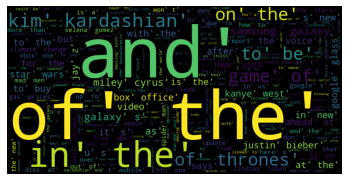

In [32]:
# store to file
cloudViz.to_file("E:\dove_wordcloud.png")

# show

plt.imshow(cloudViz)
plt.axis("off")
plt.show()

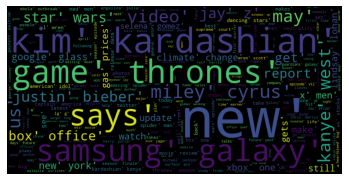

In [33]:
combined_text_filtered = ' '.join(map(str, data_cloud['filtered']))
cloudViz_filtered = WordCloud(width=800, height=400).generate(combined_text_filtered)
# store to file
cloudViz_filtered.to_file("E:\dove_wordcloud_fitered.png")

# show

plt.imshow(cloudViz_filtered)
plt.axis("off")
plt.show()

**Encode column by creating category index column**

In [34]:
indexer = StringIndexer(inputCol='CATEGORY',outputCol='CategoryIndexer')
feature_data = indexer.fit(words_df).transform(words_df)

In [35]:
feature_data.show()

+--------------------+--------+--------------------+--------------------+--------------------+---------------+
|               TITLE|CATEGORY|          JustString|               words|            filtered|CategoryIndexer|
+--------------------+--------+--------------------+--------------------+--------------------+---------------+
|Fed official says...|       b|Fed official says...|[fed, official, s...|[fed, official, s...|            1.0|
|Fed's Charles Plo...|       b|Fed's Charles Plo...|[fed, s, charles,...|[fed, charles, pl...|            1.0|
|US open: Stocks f...|       b|US open: Stocks f...|[us, open, stocks...|[us, open, stocks...|            1.0|
|Fed risks falling...|       b|Fed risks falling...|[fed, risks, fall...|[fed, risks, fall...|            1.0|
|Fed's Plosser: Na...|       b|Fed's Plosser: Na...|[fed, s, plosser,...|[fed, plosser, na...|            1.0|
|Plosser: Fed May ...|       b|Plosser: Fed May ...|[plosser, fed, ma...|[plosser, fed, ma...|            1.0|
|

In [36]:
# Convert Text into vectors of token count
cv = CountVectorizer(inputCol='filtered', outputCol='features')
model = cv.fit(feature_data)
CountVectorizer_features = model.transform(feature_data)

In [37]:
CountVectorizer_features.show()

+--------------------+--------+--------------------+--------------------+--------------------+---------------+--------------------+
|               TITLE|CATEGORY|          JustString|               words|            filtered|CategoryIndexer|            features|
+--------------------+--------+--------------------+--------------------+--------------------+---------------+--------------------+
|Fed official says...|       b|Fed official says...|[fed, official, s...|[fed, official, s...|            1.0|(49043,[5,42,112,...|
|Fed's Charles Plo...|       b|Fed's Charles Plo...|[fed, s, charles,...|[fed, charles, pl...|            1.0|(49043,[58,84,112...|
|US open: Stocks f...|       b|US open: Stocks f...|[us, open, stocks...|[us, open, stocks...|            1.0|(49043,[1,27,112,...|
|Fed risks falling...|       b|Fed risks falling...|[fed, risks, fall...|[fed, risks, fall...|            1.0|(49043,[5,112,578...|
|Fed's Plosser: Na...|       b|Fed's Plosser: Na...|[fed, s, plosser,...|[fe

# **3- DATA SAMPLING**

In [38]:
# Train and Test Dataset
(trainingData, testData) = CountVectorizer_features.randomSplit([0.8,0.2],seed=11)

In [39]:
print('training Data rows', trainingData.count())
print('training Data columns', len(trainingData.columns))
print('\ntest Data rows', testData.count())
print('test Data columns', len(testData.columns))

training Data rows 337669
training Data columns 7

test Data rows 84752
test Data columns 7


# **4 - ML ALGORITHM**

In [40]:
# Train the model Naives Bayes 
#Multinomial logistic regression is used when the dependent variable in question is nominal (equivalently categorical
#meaning that it falls into any one of a set of categories that cannot be ordered in any meaningful way) 
# and for which there are more than two categories.

nb = NaiveBayes(modelType='multinomial', labelCol='CategoryIndexer',featuresCol='features')
nbModel = nb.fit(trainingData)
nb_predictions = nbModel.transform(testData)

In [41]:
nb_predictions.select('prediction','CategoryIndexer','features').show(10)

+----------+---------------+--------------------+
|prediction|CategoryIndexer|            features|
+----------+---------------+--------------------+
|       0.0|            0.0|(49043,[21,50,111...|
|       0.0|            0.0|(49043,[20,21,22,...|
|       0.0|            0.0|(49043,[31,504,77...|
|       0.0|            0.0|(49043,[184,226,9...|
|       0.0|            0.0|(49043,[345,511,7...|
|       0.0|            0.0|(49043,[506,553,1...|
|       0.0|            0.0|(49043,[17,329,38...|
|       0.0|           20.0|(49043,[153,325,5...|
|       0.0|            0.0|(49043,[51,59,118...|
|       0.0|            0.0|(49043,[120,292,4...|
+----------+---------------+--------------------+
only showing top 10 rows



In [3]:
# Train the model Logistic Regression 
lr = LogisticRegression(labelCol='CategoryIndexer',featuresCol='features', maxIter= 10)
lrModel = lr.fit(trainingData)


NameError: name 'LogisticRegression' is not defined

In [54]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
import seaborn as sns

In [53]:
data_cloud

,TITLE,CATEGORY,JustString,words,filtered
0,"Fed official says weak data caused by weather,...",b,"Fed official says weak data caused by weather,...","[fed, official, says, weak, data, caused, by, ...","[fed, official, says, weak, data, caused, weat..."
1,Fed's Charles Plosser sees high bar for change...,b,Fed's Charles Plosser sees high bar for change...,"[fed, s, charles, plosser, sees, high, bar, fo...","[fed, charles, plosser, sees, high, bar, chang..."
2,US open: Stocks fall after Fed official hints ...,b,US open: Stocks fall after Fed official hints ...,"[us, open, stocks, fall, after, fed, official,...","[us, open, stocks, fall, fed, official, hints,..."
3,"Fed risks falling 'behind the curve', Charles ...",b,"Fed risks falling 'behind the curve', Charles ...","[fed, risks, falling, behind, the, curve, char...","[fed, risks, falling, behind, curve, charles, ..."
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,"[fed, s, plosser, nasty, weather, has, curbed,...","[fed, plosser, nasty, weather, curbed, job, gr..."
...,...,...,...,...,...
422416,Surgeons to remove 4-year-old's rib to rebuild...,m,Surgeons to remove -year-old's rib to rebuild ...,"[surgeons, to, remove, year, old, s, rib, to, ...","[surgeons, remove, year, old, rib, rebuild, da..."
422417,Boy to have surgery on esophagus after battery...,m,Boy to have surgery on esophagus after battery...,"[boy, to, have, surgery, on, esophagus, after,...","[boy, surgery, esophagus, battery, burns, hole..."
422418,Child who swallowed battery to have reconstruc...,m,Child who swallowed battery to have reconstruc...,"[child, who, swallowed, battery, to, have, rec...","[child, swallowed, battery, reconstructive, su..."
422419,Phoenix boy undergoes surgery to repair throat...,m,Phoenix boy undergoes surgery to repair throat...,"[phoenix, boy, undergoes, surgery, to, repair,...","[phoenix, boy, undergoes, surgery, repair, thr..."


In [56]:
data_cloud_sklearn = data_cloud[['CATEGORY','filtered']]

In [58]:
category_mapping = {
           'b': 'Business',
           'm': 'Health',
           'e': 'Entertainment',
           't' : 'Science and Technology'
           }

data_cloud_sklearn['CATEGORY'] = data_cloud_sklearn['CATEGORY'].map(category_mapping)
data_cloud_sklearn

C:\Users\iyfsi\AppData\Local\Temp/ipykernel_47112/2494333826.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cloud_sklearn['CATEGORY'] = data_cloud_sklearn['CATEGORY'].map(category_mapping)


,CATEGORY,filtered
0,Business,"[fed, official, says, weak, data, caused, weat..."
1,Business,"[fed, charles, plosser, sees, high, bar, chang..."
2,Business,"[us, open, stocks, fall, fed, official, hints,..."
3,Business,"[fed, risks, falling, behind, curve, charles, ..."
4,Business,"[fed, plosser, nasty, weather, curbed, job, gr..."
...,...,...
422416,Health,"[surgeons, remove, year, old, rib, rebuild, da..."
422417,Health,"[boy, surgery, esophagus, battery, burns, hole..."
422418,Health,"[child, swallowed, battery, reconstructive, su..."
422419,Health,"[phoenix, boy, undergoes, surgery, repair, thr..."


array([<AxesSubplot:ylabel='CATEGORY'>], dtype=object)

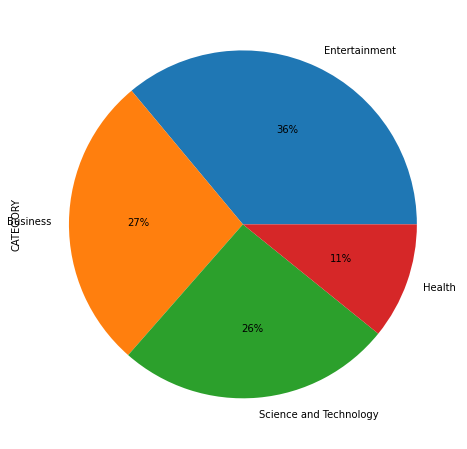

In [59]:
#visualizing the categories 
data_cloud_sklearn["CATEGORY"].value_counts().plot(kind='pie',  autopct='%1.0f%%', subplots=True, figsize=(8, 8))

# **5- SUMMARY OF PERFORMANCES**

In [42]:
#General Formula
evaluator = MulticlassClassificationEvaluator(labelCol='CategoryIndexer', predictionCol='prediction', metricName='accuracy')


In [49]:
# Naive Bayes Metrics
nb_accuracy = evaluator.evaluate(nb_predictions)
print('accuracy of NB : ', nb_accuracy)
print('test error of NB : ', 1.0-nb_accuracy)

accuracy of NB :  0.9257952614687559
test error of NB :  0.0742047385312441


In [ ]:
# Assessment of Performance on other Dataset

# **6- DEPLOYMENT USING STREAMLIT**